# Решение задачи "Анализ ЭКГ-сигналов для диагностики сердечных патологий" для конкурса AI challenge

Оглавление
- Исследование области задачи
- Обработка и анализ данных
- Тестирование различных моделей

## Исследование области задачи
- SCP-ECG - http://masters.donntu.ru/2008/kita/golovach/library/4_ref/pub.html
- стадии инфаркта

## Обработка и анализ данных

Локальные переменные

In [2]:
import os
os.environ['DATA_DIR'] = './data' # ты указываешь путь к своей папке

Используемые модули

In [3]:
# Для данных
import pandas as pd
import numpy as np
import json
import os

# Для плюшек 
import sklearn as sk

# Для красоты
import seaborn as sns
from pprint import pprint
import typing

Полезные функции

In [4]:
def get_hr(folder: str, hr_num: str) -> np.array:
    with open(f'{os.environ["DATA_DIR"]}/{folder}/{hr_num}.npy', "rb") as f:
        return np.load(f, allow_pickle=True)


def flatten_list(lst: typing.List[any]) -> typing.List[any]:
    new_lst = []
    for elem in lst:
        if isinstance(elem, list):
            new_lst.extend(flatten_list(elem))
        else:
            new_lst.append(elem)
            
    return new_lst

def global_info(meta: pd.DataFrame):
    for column in meta.columns:
        print(f'Column name: {column} {round(meta[column].notna().sum() / len(meta) * 100, 2)}%')
        print(meta[column].value_counts() if len(meta[column].unique()) < 14 else f'so much unique values\n{meta[column].describe()}')
        print()

Пример использования

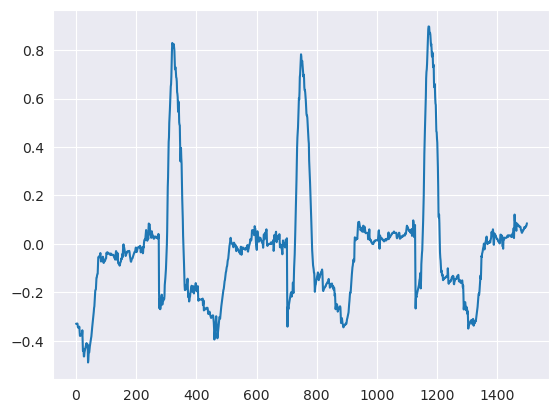

In [5]:
a = get_hr(folder='train', hr_num='15857_hr')
sns.lineplot(data=a.flatten()[:1500])

ecg_columns = ['report', 'scp_codes', 'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'validated_by', 
'second_opinion', 'initial_autogenerated_report', 'validated_by_human', 'baseline drift', 'static_noise', 'burst_noise', 'electrodes_problems', 
'extra_beats']

Загрузка данных

In [6]:
meta = pd.read_csv(f'{os.environ["DATA_DIR"]}/train/train_meta.csv')
diagnosis = pd.read_csv(f'{os.environ["DATA_DIR"]}/train/train_gts.csv')

In [7]:
meta.head(3)

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
0,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,00009_hr,1
1,34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,00034_hr,3
2,43,11315.0,25.0,1,NaN,63.0,2.0,0.0,CS-12 E,1985-03-14 09:38:53,...,NaN,NaN,NaN,NaN,NaN,8,records100/00000/00043_lr,records500/00000/00043_hr,00043_hr,3


In [8]:
diagnosis.head(3)

,record_name,myocard
0,00669_hr,0
1,00209_hr,0
2,00777_hr,0


In [9]:
diagnosis['myocard'].value_counts()

0    1686
1     415
Name: myocard, dtype: int64

Просмотрим информацию о нашем датасете </br>
https://physionet.org/content/ptb-xl/1.0.3/ - еще здесь нада

In [10]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        2101 non-null   int64  
 1   patient_id                    2101 non-null   float64
 2   age                           2101 non-null   float64
 3   sex                           2101 non-null   int64  
 4   height                        689 non-null    float64
 5   weight                        905 non-null    float64
 6   nurse                         1947 non-null   float64
 7   site                          2100 non-null   float64
 8   device                        2101 non-null   object 
 9   recording_date                2101 non-null   object 
 10  report                        2101 non-null   object 
 11  scp_codes                     2101 non-null   object 
 12  heart_axis                    1231 non-null   object 
 13  inf

Удалим те данные, которые не несут важной для нас информации

In [11]:
useless_columns = ['ecg_id', 'patient_id', 'nurse', 'site', 'device', 'recording_date', 'filename_lr', 'filename_hr', 'report']
meta.drop(columns=useless_columns, inplace=True)

Создадим список тех столбцов, которые возможно не несут важной информации (мы проверим это при обучении)

In [12]:
strange_columns = ['age', 'sex', 'pacemaker', 'group']

Рассмотрим те столбцы, в которых есть много пропусков

In [13]:
global_info(meta)

Column name: age 100.0%
so much unique values
count    2101.000000
mean       62.581152
std        31.758759
min         3.000000
25%        50.000000
50%        61.000000
75%        72.000000
max       300.000000
Name: age, dtype: float64

Column name: sex 100.0%
0    1095
1    1006
Name: sex, dtype: int64

Column name: height 32.79%
so much unique values
count    689.000000
mean     167.343977
std       10.479595
min      100.000000
25%      160.000000
50%      167.000000
75%      175.000000
max      209.000000
Name: height, dtype: float64

Column name: weight 43.07%
so much unique values
count    905.000000
mean      71.605525
std       15.397469
min       16.000000
25%       61.000000
50%       70.000000
75%       80.000000
max      180.000000
Name: weight, dtype: float64

Column name: scp_codes 100.0%
so much unique values
count                           2101
unique                           802
top       {'NORM': 100.0, 'SR': 0.0}
freq                             597
Name: scp_co

На основе этих данных выделим список столбцов с множество недостающих значений

In [14]:
empty_columns = ['height', 'weight', 'heart_axis']
meta.drop(columns=empty_columns, inplace=True)

Удалим те строки, в которых electrodes_problem

In [15]:
meta.drop(meta[meta['electrodes_problems'].notna()].index, inplace=True)
meta.drop(columns=['electrodes_problems'], inplace=True)
meta.drop(1514, inplace=True) # Хех пока

In [16]:
meta = meta.reset_index(drop=True)

#### age
- определение: возраст
- диапозон от 3 до 300.
#### sex
- определение: пол
- мужской(1), женский(0).
#### report
- определение: строка отчета, сгенерированная кардиологом или автоматически интерпретируемая ЭКГ-устройством, которая была преобразована в стандартизированный набор выписок SCP-ЭКГ (scp_codes)
- диапозон безумно большой.
#### scp_codes
- определение: SCP-показания ЭКГ
- в виде словаря с записями вида statement: likelihoodгде вероятность установлена равной 0, если неизвестно, диапозон безумно большой.
#### infarction_stadium1
- определение: стадия инфаркта1
- диапозон['Stadium I', 'Stadium I-II', 'Stadium II', 'Stadium II-III', 'Stadium III'].
#### infarction_stadium2
- определение: стадия инфаркта2
- диапозон['Stadium I', 'Stadium II', 'Stadium III'].
#### validated_by
- определение: в переводчике пишет "подтверждено" 
- диапозон от 0 до 9.
#### second_opinion
- определение: второе мнение(консультация второго специалиста)
- диапозон состоит из True и False.
#### initial_autogenerated_report
- определение: первоначальный автоматически сгенерированный отчет
- диапозон состоит из True и False. 
#### validated_by_human
- определение: подтверждено человеком
- диапозон состоит из True и False. 
#### baseline_drift
- определение: смещение базовой линии (на самой экг карточки(npy))
- диапозон *noise_types*
#### static_noise
- определение: статический шум
- диапозон *noise_types*
#### burst_noise
- определение: Шум взрыва — тип электронного шума, который возникает в полупроводниках и ультратонких оксидных пленках затвора
- диапозон большой
#### extra_beats
- определение: дополнительные удары, предоставляемые для подсчета дополнительных систол и кардиостимулятор для получения паттернов сигналов, указывающих на активный кардиостимулятор
- диапозон['1,V1,V2', '1,V2', '1ES', '1VES', '2,V1', '2,V3', '2,V4', '2ES', '2ES,SVES', '3,alles', '3ES', '4ES', '4VES', '5,alles', 'ES', 'SVES', 'SVES1,V5', 'SVES1,alles', 'VES', 'VES,SVES', 'VES,SVES1,alles', 'VES,SVES3,alles', 'VES1,II-AVF', 'VES1,II-V6', 'VES1,alles', 'VES2,alles', 'VES3,alles', 'VES4,alles', 'VES6,alles'].
#### pacemaker
- определение: кардиостимулятор
- диапозон['PACE????, nan', 'ja, pacemaker'].
#### strat_fold
- определение: свертки перекрестной проверки: рекомендуемые 10-кратные разбиения для поездных тестов, полученный с помощью стратифицированной выборки с учетом распределения пациентов, т. е. все записи конкретного пациента были отнесены к одному и тому же сгибу
- Записи в fold 9 и 10 прошли по крайней мере одну оценку человеком и поэтому имеют особенно высокое качество маркировки. Поэтому мы предлагаем использовать fold 1-8 в качестве обучающего набора, fold 9 в качестве набора для проверки и fold 10 в качестве набора для тестирования, диапозон от 1 до 10
#### record_name
- определение: имя записи
- состоит из 5 цифр и после цифр идет '_hr'
#### group
- определение: группа
- диапозон от 1 до 3

In [17]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           2096 non-null   float64
 1   sex                           2096 non-null   int64  
 2   scp_codes                     2096 non-null   object 
 3   infarction_stadium1           507 non-null    object 
 4   infarction_stadium2           10 non-null     object 
 5   validated_by                  1239 non-null   float64
 6   second_opinion                2096 non-null   bool   
 7   initial_autogenerated_report  2096 non-null   bool   
 8   validated_by_human            2096 non-null   bool   
 9   baseline_drift                150 non-null    object 
 10  static_noise                  308 non-null    object 
 11  burst_noise                   41 non-null     object 
 12  extra_beats                   174 non-null    object 
 13  pac

Обработаем оствашиеся не числовые столбцы (кроме report и record_name и категориальных)
- baseline_drift
- static_noise
- scp_codes

In [18]:
noise_types = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

def str_to_noise(s: str) -> typing.List[str]:
    if not isinstance(s, str):
        return []
    noises = []
    
    if 'alles' in s: # alles - all
        return noise_types
    
    vnable = False
    for elem in s.split(','):
        elem = elem.strip(',- ').upper()
        if not elem:
            continue
        if 'V' in elem and 'A' not in elem:
            vnable = True
        else:
            if vnable and elem in map(str, range(1, 7)):
                elem = 'V' + elem
        if '-' in elem:
            elem = elem.split('-')
            if 'V' in elem[0] and 'V' not in elem[1]:
                elem[1] = 'V' + elem[1]
            noises.extend(noise_types[noise_types.index(elem[0].strip(',- ')):noise_types.index(elem[1].strip(',- '))+1])
        else:
            noises.append(elem)
            
    return noises

def scp_convert(s: str) -> typing.Dict[str, int]:
    return json.loads(s.replace("'", '"'))

Превращение в список

In [19]:
meta['baseline_drift'] = meta['baseline_drift'].apply(str_to_noise)
meta['static_noise'] = meta['static_noise'].apply(str_to_noise)
params = set(flatten_list([list(eval(codes).keys()) for codes in meta['scp_codes'].unique().tolist()]))
meta['scp_codes'] = meta['scp_codes'].apply(scp_convert)

static_noise

In [20]:
for elem in noise_types:
    meta[f'static_noise_{elem}'] = False
    for id, row in meta.iterrows():
        meta.loc[id, f'static_noise_{elem}'] = bool(elem in row['static_noise'])

baseline_drift

In [21]:
for elem in noise_types:
    meta[f'baseline_drift_{elem}'] = False
    for id, row in meta.iterrows():
        meta.loc[id, f'baseline_drift_{elem}'] = bool(elem in row['baseline_drift'])

scp_codes

In [22]:
for elem in params:
    meta[f'scp_{elem}'] = meta['scp_codes'].apply(lambda x: x.get(elem))

Пока пока

In [23]:
meta.drop(columns=['baseline_drift', 'static_noise', 'scp_codes'], inplace=True)

Заменим строки в названиях, так как они малину портят

In [24]:
str_columns = ['infarction_stadium1', 'infarction_stadium2', 'burst_noise', 'pacemaker', 'extra_beats']

meta = pd.get_dummies(meta, columns=str_columns, dtype=bool)

In [25]:
global_info(meta)

Column name: age 100.0%
so much unique values
count    2096.000000
mean       62.454198
std        31.366976
min         3.000000
25%        50.000000
50%        61.000000
75%        72.000000
max       300.000000
Name: age, dtype: float64

Column name: sex 100.0%
0    1093
1    1003
Name: sex, dtype: int64

Column name: validated_by 59.11%
0.0    603
1.0    522
2.0     52
3.0     28
4.0      9
7.0      9
5.0      7
6.0      6
8.0      2
9.0      1
Name: validated_by, dtype: int64

Column name: second_opinion 100.0%
False    2031
True       65
Name: second_opinion, dtype: int64

Column name: initial_autogenerated_report 100.0%
False    1470
True      626
Name: initial_autogenerated_report, dtype: int64

Column name: validated_by_human 100.0%
True     1575
False     521
Name: validated_by_human, dtype: int64

Column name: strat_fold 100.0%
8     232
10    230
3     222
5     217
9     216
2     215
6     204
7     200
4     187
1     173
Name: strat_fold, dtype: int64

Column name: reco

Добавление столбцов с ЭКГ записями

In [ ]:
hr_example = get_hr('train', '00034_hr').flatten()

In [ ]:
hrs = pd.DataFrame([get_hr('train', hr_name).flatten() for hr_name in meta['record_name']])

In [ ]:
meta = pd.concat([meta, hrs], axis=1)

In [ ]:
meta.info()

Разбеиние на обучающую и тестовую выборки

In [26]:
train_meta = meta.loc[meta['strat_fold'] > 8].drop(columns=['strat_fold'])
test_meta = meta.loc[meta['strat_fold'] < 9].drop(columns=['strat_fold'])

In [27]:
train_diagnosis = diagnosis.loc[diagnosis['record_name'].isin(train_meta['record_name'])]
test_diagnosis = diagnosis.loc[diagnosis['record_name'].isin(test_meta['record_name'])]

In [28]:
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446 entries, 0 to 2094
Columns: 164 entries, age to extra_beats_VES6,alles
dtypes: bool(90), float64(71), int64(2), object(1)
memory usage: 300.5+ KB


In [29]:
train_diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446 entries, 3 to 2100
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   record_name  446 non-null    object
 1   myocard      446 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.5+ KB


In [30]:
test_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1650 entries, 2 to 2095
Columns: 164 entries, age to extra_beats_VES6,alles
dtypes: bool(90), float64(71), int64(2), object(1)
memory usage: 1.1+ MB


In [31]:
test_diagnosis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1650 entries, 0 to 2099
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   record_name  1650 non-null   object
 1   myocard      1650 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.7+ KB


In [ ]:
# TODO reset_index + sort

## Тестирование различных моделей

Используемые модули (не точно)

In [ ]:
# Нейронки (какие-то уберем, разобраться сначала, какие для этого подходят)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

# Посложнее, что успеем сделать
import torch #1
import keras #2

# Метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score